# How many preliminary experiments?

This notebook shows how smany preliminary experiments $N$ are enough to ensure a reasonable estimation of $n^*$ using $n^*_N$.
We will use different probability distributions over rankings to evaluate this and provide some recommendations.

In [1]:
from typing import OrderedDict

import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.auto import tqdm

from genexpy.kernels import rankings as kru
from genexpy import random as du

figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True, parents=True)
outputs_dir = Path("outputs")
outputs_dir.mkdir(exist_ok=True, parents=True)

seed = 1444
nrep = 100
infty = 5000  # a "very large" N
alpha = 0.95
delta = 0.05
load_precomputed = True

# Distributions
nas = [2, 4, 8, 16]
distrs = [du.UniformDistribution(na=na, seed=seed*na) for na in nas]

# Sizes of preliminary studies
Ns = [10, 20, 40, 80]

First, for all distributions, kernels, and $N$-s (including $\infty$), let's estimate the distribution of the MMD for various $n \leq N // 2$.

In [2]:
if load_precomputed:
    try:
        dfmmd = pd.read_parquet(outputs_dir / "dfmmd.parquet")
    except FileNotFoundError:
        pass
    else:
        print(f"[INFO] Loaded existing results from {outputs_dir / 'dfmmd.parquet'}.")

out = []
tmp_seed = seed
for distr in tqdm(distrs, desc="Distribution", position=0, leave=True):
    # True results (for a very large number of experiments)
    na = distr.na

    # Kernels (not instantiated because we need na)
    kernels = [kru.BordaKernel(idx=0, nu="auto", na=na),
               kru.JaccardKernel(k=1),
               kru.MallowsKernel(nu="auto", na=na),
               ]

    for kernel in tqdm(kernels, desc="Kernel", position=1, leave=False):
        # True value for N = \infty
        sample_infty = distr.sample(infty)
        tmp = kernel.mmd_distribution_many_n(sample_infty, nmin=2, nmax=40, step=2, rep=100, seed=tmp_seed, disjoint=True, replace=False,method="vectorized", N=infty)
        tmp["rep"] = 0
        tmp["distr"] = str(distr)
        tmp["distr_latex"] = distr.latex_str()
        tmp["na"] = na
        out.append(tmp)

        tmp_seed += 1

        # Estimations
        for N in Ns:
            for rep in range(nrep):
                sample = distr.sample(n=N)
                # sample = sample_infty.get_subsample(subsample_size=N, seed=tmp_seed)
                tmp_seed += 1

                tmp = kernel.mmd_distribution_many_n(sample_infty, nmin=2, nmax=N//2, step=2, rep=100, seed=tmp_seed, disjoint=True, replace=False, method="vectorized", N=N)
                tmp["rep"] = rep
                tmp["distr"] = str(distr)
                tmp["distr_latex"] = distr.latex_str()
                tmp["na"] = na
                out.append(tmp)

                tmp_seed += 1

dfmmd = pd.concat(out, axis=0)
dfmmd.to_parquet(outputs_dir / "dfmmd.parquet")


Distribution:   0%|          | 0/4 [00:00<?, ?it/s]

Kernel:   0%|          | 0/3 [00:00<?, ?it/s]

Kernel:   0%|          | 0/3 [00:00<?, ?it/s]

Kernel:   0%|          | 0/3 [00:00<?, ?it/s]

Kernel:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dfmmd.head()

,n,mmd,method,N,disjoint,replace,kernel,rep,distr,distr_latex,na
0,2,4.435478e-01,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
1,2,0.000000e+00,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
2,2,0.000000e+00,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
3,2,4.435478e-01,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
4,2,1.490116e-08,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2


In [29]:
a = dfmmd.query("distr_latex == '$U_{16}$'").query("N == 20").query("kernel == 'BordaKernel(nu=0.06, idx=0)'").query("n == 8")
a.groupby("rep")["mmd"].mean()

rep
0     0.222669
1     0.240254
2     0.240668
3     0.247885
4     0.232900
        ...   
95    0.226815
96    0.244112
97    0.235818
98    0.235015
99    0.229492
Name: mmd, Length: 100, dtype: float64

In [49]:
for group, b in a.groupby("rep"):
    print(group, b["mmd"].mean(), a.query("rep == @group")["mmd"].mean())


0 0.22266895283856059 0.22266895283856059
1 0.24025429090812486 0.24025429090812486
2 0.24066827021181245 0.24066827021181245
3 0.24788538123315385 0.24788538123315385
4 0.23289967549348323 0.23289967549348323
5 0.24197604596453218 0.24197604596453218
6 0.2360655539325997 0.2360655539325997
7 0.24244024794467894 0.24244024794467894
8 0.23186248857798705 0.23186248857798705
9 0.2547050565607445 0.2547050565607445
10 0.23337617652306453 0.23337617652306453
11 0.23246159810712283 0.23246159810712283
12 0.24941712278788544 0.24941712278788544
13 0.252057520760093 0.252057520760093
14 0.2446305550008024 0.2446305550008024
15 0.2369298433103085 0.2369298433103085
16 0.22225942730013887 0.22225942730013887
17 0.25354717754785566 0.25354717754785566
18 0.2523335722270211 0.2523335722270211
19 0.2364698035512593 0.2364698035512593
20 0.24731116750436155 0.24731116750436155
21 0.22946605147720148 0.22946605147720148
22 0.2281401324601662 0.2281401324601662
23 0.2371106603500982 0.237110660350098

Next, we compute the quantiles of the mmd.

In [50]:
groupby_keys = ["distr_latex", "na", "kernel", "N", "rep"]

out = []
for group, tmp in dfmmd.groupby(groupby_keys):
    tmp2 = tmp.groupby("n")["mmd"].quantile(alpha, interpolation="higher").rename("q_alpha").reset_index()

    for key, val in zip(groupby_keys, tuple(group)):
        tmp2[key] = val

    out.append(tmp2)

dfq = pd.concat(out, axis=0)

0.41460350131712415
0.3984576146602994
0.40799017434211854
0.40615862136956055
0.43407669558989304
0.41892450499769285
0.40499190501533705
0.42500536200093125
0.4190384572621032
0.403918379682507
0.41578451772820096
0.3943548497200655
0.4063450966177939
0.4149914847564595
0.4063359295371245
0.41809395053640924
0.4032448225026402
0.4161265480141416
0.39498964277991194
0.40725460844244366
0.4137015677736177
0.41261176826966994
0.42518867528703835
0.4279120855215312
0.41496490037561584
0.4050940076203777
0.41888689138217244
0.4044326167300822
0.41718001555857775
0.40043477280066525
0.4198040352526729
0.42413552054793047
0.4188899805566982
0.406156511957063
0.42040950827323564
0.3985811413646689
0.4183914269443521
0.3844640782389536
0.4084112886951661
0.40838939086949744
0.3986073967577007
0.40868548203079413
0.40722178526276126
0.41618610897372704
0.4212132842804683
0.43732625998453345
0.4067531712303516
0.41251049993296773
0.4066756023242303
0.4294830783457285
0.4228591841877936
0.396686

In [51]:
dfq.head()

,n,q_alpha,distr_latex,na,kernel,N,rep
0,2,0.827036,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,0
1,4,0.617147,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,0
0,2,0.865488,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,1
1,4,0.529262,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,1
0,2,0.783971,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,2


Now we predict generalizability for with the quantiles.

In [52]:
from sklearn.linear_model import LinearRegression
from genexpy.kernels.base import Kernel

groupby_keys = ["distr_latex", "na", "kernel", "N", "rep"]

out = []
for group, dftmp in dfq.groupby(groupby_keys):
    group = tuple(group)

    logq = np.log(dftmp["q_alpha"].values.reshape(-1, 1))
    logn = np.log(dftmp["n"].values.reshape(-1, 1))

    # logn = b1 * logq + b0
    lr = LinearRegression()
    lr.fit(logq, logn)
    b1 = lr.coef_[0, 0]
    b0 = lr.intercept_[0]

    distr = group[0]
    na = group[1]

    kernel = Kernel.from_string(group[2])
    eps = kernel.get_eps(delta, na=na)
    nstar = np.exp(b1 * np.log(eps) + b0)

    out.append(dict(zip(groupby_keys, group),
                    **dict(nstar=nstar)))

df_nstar = pd.DataFrame(out)

C:\Users\federicom\AppData\Local\Temp\ipykernel_14292\3028870393.py:24: RuntimeWarning: overflow encountered in exp
  nstar = np.exp(b1 * np.log(eps) + b0)


In [53]:
df_nstar.head()

,distr_latex,na,kernel,N,rep,nstar
0,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,0,21.033813
1,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,1,8.651773
2,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,2,11.865063
3,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,3,16.035818
4,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,4,13.946708


Finally, we compare the estimated $n^*_N$-s against the true one, for $N=\infty$.

In [71]:
df_nstar_infty = df_nstar.query("N == @infty").reset_index(drop=True).drop(columns=["rep", "N"])
df_nstar_emp = df_nstar.query("N < @infty").reset_index(drop=True).drop(columns=["rep"])

dfplot = pd.merge(df_nstar_emp, df_nstar_infty, on=["distr_latex", "na", "kernel"], suffixes=("", "_true"))

dfplot["nstar_rel_error"] = (dfplot["nstar"] - dfplot["nstar_true"]) / dfplot["nstar_true"]

dfplot.head()

,distr_latex,na,kernel,N,nstar,nstar_true,nstar_rel_error
0,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,21.033813,14.728664,0.428087
1,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,8.651773,14.728664,-0.412589
2,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,11.865063,14.728664,-0.194424
3,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,16.035818,14.728664,0.088749
4,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,13.946708,14.728664,-0.053091


In [72]:
boxplot_args = dict(
            showfliers=False, palette="cubehelix",
            dodge=True, native_scale=False, fill=False, width=0.75, boxprops={"linewidth": 1.2}, gap=0.25
        )

pretty_columns = dict(
    nstar_rel_error=r"$\frac{\hat{n}^*_N - n^*}{n^*}$",
    N=r"$N$",
)

# Cosmetic modifications
dfplot.loc[:, "kernel_latex"] = dfplot["kernel"].apply(lambda x: Kernel.from_string(x).latex_str())

# dfplot = dfplot.drop(columns=["kernel"])

dfplot = dfplot.rename(columns=pretty_columns)

Index(['distr_latex', 'na', 'kernel', '$N$', 'nstar', 'nstar_true',
       '$\frac{\hat{n}^*_N - n^*}{n^*}$', 'kernel_latex'],
      dtype='object')


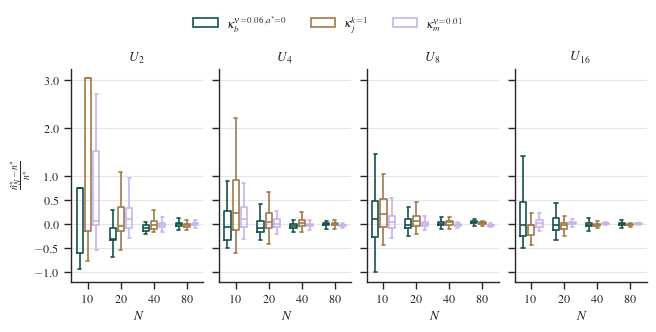

In [86]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns

mpl.rcParams['text.usetex'] = True                     # enable LaTeX
mpl.rcParams['text.latex.preamble'] = r"""
    \usepackage{mathptmx}
    \usepackage{amsmath}
    \usepackage{nicefrac}
"""
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman"],
})
sns.set(style="ticks", context="paper", font="serif")


linewidth = 6.5  # inches
fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(linewidth, 0.5*linewidth))
axes = axes.flatten()

groups = dfplot.groupby("distr_latex").groups

def sort_keys_by_subscript(d):
    def _extract_number(key):
        m = re.search(r'\{(\d+)\}', str(key))
        if m:
            return int(m.group(1))

        m = re.search(r'(\d+)', str(key))
        return int(m.group(1)) if m else float('inf')   # keys without a number go to the end

    sorted_keys = sorted(d.keys(), key=_extract_number)

    return sorted_keys

groups = OrderedDict({k: groups[k] for k in sort_keys_by_subscript(groups)})

handles, labels = None, None
for (distr_name, idx), ax in zip(groups.items(), axes):
    ax.set_title(distr_name)

    df_ = dfplot.iloc[idx, :]
    sns.boxplot(data=df_, x=pretty_columns["N"], y=pretty_columns["nstar_rel_error"], hue="kernel_latex", ax=ax, **boxplot_args)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()

    ax.set_yticks([-1, -0.5, 0, 0.5, 1, 2, 3])
    ax.grid(color="grey", alpha=0.2, axis="y")


sns.despine(top=True, right=True)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=.12, top=0.8)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0, 0.82 + 0.02, 1, 0.2),
           loc="center", borderaxespad=1, ncol=3, frameon=False)

fig.savefig(figures_dir / "nstar_estimation_rel_error.pdf")
